# Aviation Safety Analysis

Introduction:

This project analyzes Aviation accident data to determine the lowest-risk aircraft for a new aviation division. The goal is to provide actionable insights to help the company decide which aircraft to purchase, focusing on minimizing risk.

## Data Preparation

Data Understanding Dataset: Aviation accident data from 1962 to 2023 from the National Transportation Safety Board (NTSB)

Source: https//;kagle.com//



Data Loading and Processing

In [1]:

pip install tabulate


Note: you may need to restart the kernel to use updated packages.


In [2]:
#Import Libraries and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

# Display options for better readability
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

     

# Read the CSV file into a DataFrame using latin1 encoding
df = pd.read_csv('C:\\Users\\USER\\Desktop\\olonde\\data\\AviationData.csv', encoding='latin1')

In [3]:
#Explore the data frames Columns 
df.columns

Index(['Event.Id', 'Investigation.Type', 'Accident.Number', 'Event.Date',
       'Location', 'Country', 'Latitude', 'Longitude', 'Airport.Code',
       'Airport.Name', 'Injury.Severity', 'Aircraft.damage',
       'Aircraft.Category', 'Registration.Number', 'Make', 'Model',
       'Amateur.Built', 'Number.of.Engines', 'Engine.Type', 'FAR.Description',
       'Schedule', 'Purpose.of.flight', 'Air.carrier', 'Total.Fatal.Injuries',
       'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured',
       'Weather.Condition', 'Broad.phase.of.flight', 'Report.Status',
       'Publication.Date'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

## Data Understanding

In [5]:
df.columns = [col.replace('.', '_') for col in df.columns]

In [6]:
df.columns


Index(['Event_Id', 'Investigation_Type', 'Accident_Number', 'Event_Date',
       'Location', 'Country', 'Latitude', 'Longitude', 'Airport_Code',
       'Airport_Name', 'Injury_Severity', 'Aircraft_damage',
       'Aircraft_Category', 'Registration_Number', 'Make', 'Model',
       'Amateur_Built', 'Number_of_Engines', 'Engine_Type', 'FAR_Description',
       'Schedule', 'Purpose_of_flight', 'Air_carrier', 'Total_Fatal_Injuries',
       'Total_Serious_Injuries', 'Total_Minor_Injuries', 'Total_Uninjured',
       'Weather_Condition', 'Broad_phase_of_flight', 'Report_Status',
       'Publication_Date'],
      dtype='object')

In [7]:
df.head(10)

,Event_Id,Investigation_Type,Accident_Number,Event_Date,Location,Country,Latitude,Longitude,Airport_Code,Airport_Name,Injury_Severity,Aircraft_damage,Aircraft_Category,Registration_Number,Make,Model,Amateur_Built,Number_of_Engines,Engine_Type,FAR_Description,Schedule,Purpose_of_flight,Air_carrier,Total_Fatal_Injuries,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_phase_of_flight,Report_Status,Publication_Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,Fatal(2),Destroyed,NaN,NC6404,Stinson,108-3,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,Fatal(4),Destroyed,NaN,N5069P,Piper,PA24-180,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,Fatal(3),Destroyed,NaN,N5142R,Cessna,172M,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,Fatal(2),Destroyed,NaN,N1168J,Rockwell,112,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,Fatal(1),Destroyed,NaN,N15NY,Cessna,501,No,NaN,NaN,NaN,NaN,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980
5,20170710X52551,Accident,NYC79AA106,1979-09-17,"BOSTON, MA",United States,42.445277,-70.758333,NaN,NaN,Non-Fatal,Substantial,Airplane,CF-TLU,Mcdonnell Douglas,DC9,No,2.0,Turbo Fan,Part 129: Foreign,SCHD,NaN,Air Canada,NaN,NaN,1.0,44.0,VMC,Climb,Probable Cause,19-09-2017
6,20001218X45446,Accident,CHI81LA106,1981-08-01,"COTTON, MN",United States,NaN,NaN,NaN,NaN,Fatal(4),Destroyed,NaN,N4988E,Cessna,180,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,4.0,0.0,0.0,0.0,IMC,Unknown,Probable Cause,06-11-2001
7,20020909X01562,Accident,SEA82DA022,1982-01-01,"PULLMAN, WA",United States,NaN,NaN,NaN,BLACKBURN AG STRIP,Non-Fatal,Substantial,Airplane,N2482N,Cessna,140,No,1.0,Reciprocating,Part 91: General Aviation,NaN,Personal,NaN,0.0,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,01-01-1982
8,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,NaN,NaN,N58,HANOVER,Non-Fatal,Substantial,Airplane,N7967Q,Cessna,401B,No,2.0,Reciprocating,Part 91: General Aviation,NaN,Business,NaN,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,01-01-1982
9,20020909X01560,Accident,MIA82DA029,1982-01-01,"JACKSONVILLE, FL",United States,NaN,NaN,JAX,JACKSONVILLE INTL,Non-Fatal,Substantial,NaN,N3906K,North American,NAVION L-17B,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,0.0,0.0,3.0,0.0,IMC,Cruise,Probable Cause,01-01-1982


**Drop Irrelevant Columns**

In [8]:
# Drop columns that are not used in the analysis
columns_to_keep = ['Event_Date', 'Investigation_Type', 'Make', 'Model',  'Total_Fatal_Injuries', 'Total_Serious_Injuries', 'Total_Minor_Injuries','Total_Uninjured', 'Weather_Condition', 'Broad_phase_of_flight']
df = df[columns_to_keep]

In [9]:
df.tail()

,Event_Date,Investigation_Type,Make,Model,Total_Fatal_Injuries,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_phase_of_flight
88884,2022-12-26,Accident,PIPER,PA-28-151,0.0,1.0,0.0,0.0,NaN,NaN
88885,2022-12-26,Accident,BELLANCA,7ECA,0.0,0.0,0.0,0.0,NaN,NaN
88886,2022-12-26,Accident,AMERICAN CHAMPION AIRCRAFT,8GCBC,0.0,0.0,0.0,1.0,VMC,NaN
88887,2022-12-26,Accident,CESSNA,210N,0.0,0.0,0.0,0.0,NaN,NaN
88888,2022-12-29,Accident,PIPER,PA-24-260,0.0,1.0,0.0,1.0,NaN,NaN


Merge 'Make' and 'Model' for more precesiion

In [10]:
# Merge 'Make' and 'Model' into a single 'Aircraft' column
df['Aircraft'] = df['Make'] + ' ' + df['Model']

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event_Date              88889 non-null  object 
 1   Investigation_Type      88889 non-null  object 
 2   Make                    88826 non-null  object 
 3   Model                   88797 non-null  object 
 4   Total_Fatal_Injuries    77488 non-null  float64
 5   Total_Serious_Injuries  76379 non-null  float64
 6   Total_Minor_Injuries    76956 non-null  float64
 7   Total_Uninjured         82977 non-null  float64
 8   Weather_Condition       84397 non-null  object 
 9   Broad_phase_of_flight   61724 non-null  object 
 10  Aircraft                88777 non-null  object 
dtypes: float64(4), object(7)
memory usage: 7.5+ MB


Calculate the Total Number of People Involved in Each Accident:

In [12]:

# Filter to only include accidents
df_accidents = df[df['Investigation_Type'] == 'Accident'].copy()

# Convert `Event.Date` to datetime
df_accidents['Event_Date'] = pd.to_datetime(df_accidents['Event_Date'])

# Filter to accidents after 1980-01-01
df_accidents_filtered = df_accidents[df_accidents['Event_Date'] > '1990-01-01'].copy()


# Calculate the total number of people involved in each accident
for column in ['Total_Fatal_Injuries', 'Total_Serious_Injuries', 'Total_Minor_Injuries', 'Total_Uninjured']:
    df_accidents_filtered[column] = pd.to_numeric(df_accidents_filtered[column], errors='coerce').fillna(0)

df_accidents_filtered['Total_Involved'] = df_accidents_filtered['Total_Fatal_Injuries'] + df_accidents_filtered['Total_Serious_Injuries'] + df_accidents_filtered['Total_Minor_Injuries'] + df_accidents_filtered['Total_Uninjured']




In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event_Date              88889 non-null  object 
 1   Investigation_Type      88889 non-null  object 
 2   Make                    88826 non-null  object 
 3   Model                   88797 non-null  object 
 4   Total_Fatal_Injuries    77488 non-null  float64
 5   Total_Serious_Injuries  76379 non-null  float64
 6   Total_Minor_Injuries    76956 non-null  float64
 7   Total_Uninjured         82977 non-null  float64
 8   Weather_Condition       84397 non-null  object 
 9   Broad_phase_of_flight   61724 non-null  object 
 10  Aircraft                88777 non-null  object 
dtypes: float64(4), object(7)
memory usage: 7.5+ MB


## Data Analysis

**Group Data by Aircraft Model**

Group the filtered DataFrame by the 'Aircraft' column and calculate the total number of people involved and the total number of accidents for each model. Then, calculate the average number of people involved per accident for each Aircraft.

In [14]:
# Group by model and calculate total people involved and total accidents
df_aircraft_grouped = df_accidents_filtered.groupby('Aircraft').agg(
    Total_Involved=('Total_Involved', 'sum'),
    Total_Accidents=('Total_Involved', 'count')
).reset_index()

Calculate First Accident Date and Years in Service for Each Model

In [15]:

# Calculate people involved per accident and convert soln to integer
df_aircraft_grouped['People_Involved_per_Accident'] = (df_aircraft_grouped['Total_Involved'] / df_aircraft_grouped['Total_Accidents']).round().astype(int)


# Calculate first accident date for each model
df_first_accident = df_accidents_filtered.groupby('Aircraft')['Event_Date'].min().reset_index()
df_first_accident.rename(columns={'Event_Date': 'First_Accident_Date'}, inplace=True)

# Calculate years in service
max_date = df_accidents_filtered['Event_Date'].max()
df_first_accident['Years_In_Service'] = (max_date - df_first_accident['First_Accident_Date']).dt.days / 365



Merge Grouped Data with First Accident Date

In [16]:
# Merge with df_model_grouped
df_aircraft_grouped = df_aircraft_grouped.merge(df_first_accident, on='Aircraft', how='left')

# Filter out models with fewer than 50 accidents
df_aircraft_grouped_filtered = df_aircraft_grouped[df_aircraft_grouped['Total_Accidents'] >= 50].copy()

# Sort by years in service
df_safest = df_aircraft_grouped_filtered.sort_values('Years_In_Service', ascending=False)
df_least_safe = df_aircraft_grouped_filtered.sort_values('Years_In_Service')

In [17]:
df_safest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185 entries, 4633 to 11592
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Aircraft                      185 non-null    object        
 1   Total_Involved                185 non-null    float64       
 2   Total_Accidents               185 non-null    int64         
 3   People_Involved_per_Accident  185 non-null    int64         
 4   First_Accident_Date           185 non-null    datetime64[ns]
 5   Years_In_Service              185 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 10.1+ KB


Sort and Display the Safest Aircraft

In [18]:
# Labeling the safest and least safe models
safest_aircraft = df_safest.head(15)
least_safe_aircraft = df_least_safe.head(15)

# Show the top 10 safest and least safe models
print("Safest Models (Most Years in Service):")
print(df_safest[['Aircraft', 'Years_In_Service', 'People_Involved_per_Accident']].head(10).to_markdown(index=False, numalign="left", stralign="left"))



Safest Models (Most Years in Service):
| Aircraft         | Years_In_Service   | People_Involved_per_Accident   |
|:-----------------|:-------------------|:-------------------------------|
| Cessna 150       | 33.011             | 1                              |
| Cessna 172M      | 33.0082            | 2                              |
| Piper PA-28R-200 | 33.0082            | 2                              |
| Cessna 152       | 33.0082            | 1                              |
| Cessna 172RG     | 33.0027            | 2                              |
| Piper PA-30      | 33.0027            | 2                              |
| Cessna 185       | 33.0027            | 2                              |
| Piper PA-28-140  | 33.0027            | 2                              |
| Cessna 172       | 33                 | 2                              |
| Hughes 269C      | 33                 | 2                              |


Least Safe Aircraft

In [19]:
print("\nLeast Safe Aircrafts (Fewest Years in Service):")
print(df_least_safe[['Aircraft', 'Years_In_Service', 'People_Involved_per_Accident']].head(10).to_markdown(index=False, numalign="left", stralign="left"))



Least Safe Aircrafts (Fewest Years in Service):
| Aircraft                           | Years_In_Service   | People_Involved_per_Accident   |
|:-----------------------------------|:-------------------|:-------------------------------|
| PIPER PA 18-150                    | 9.31233            | 2                              |
| CESSNA 208                         | 14.0685            | 7                              |
| BEECH 58                           | 14.0932            | 3                              |
| ROBINSON HELICOPTER COMPANY R44 II | 14.1205            | 2                              |
| ROBINSON HELICOPTER R44            | 14.137             | 2                              |
| ROBINSON R22                       | 14.211             | 2                              |
| CESSNA 172P                        | 14.2192            | 2                              |
| ROBINSON R44                       | 14.2521            | 2                              |
| AERONCA 7AC        

### Explore Correlations

**Safety vs. Years in Service Scatter Plot**

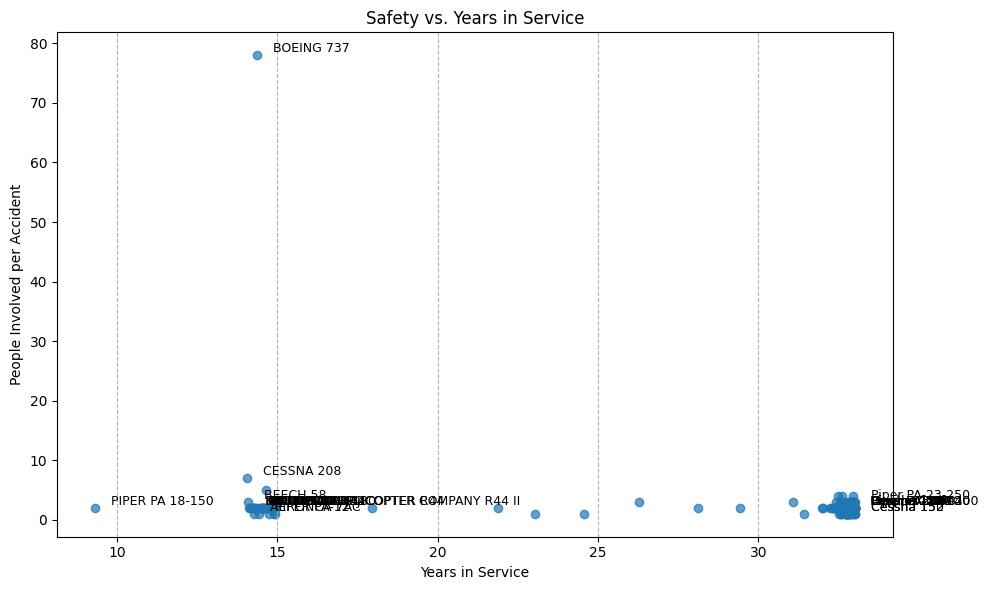

In [20]:
#Safety vs. Years in Service Scatter Plot

plt.figure(figsize=(10, 6))
plt.scatter(df_aircraft_grouped_filtered['Years_In_Service'], df_aircraft_grouped_filtered['People_Involved_per_Accident'], alpha=0.7)
plt.title('Safety vs. Years in Service')
plt.xlabel('Years in Service')
plt.ylabel('People Involved per Accident')



for i, row in safest_aircraft.iterrows():
    plt.text(row['Years_In_Service'] + 0.5, row['People_Involved_per_Accident'] + 0.5, row['Aircraft'], fontsize=9)

for i, row in least_safe_aircraft.iterrows():
    plt.text(row['Years_In_Service'] + 0.5, row['People_Involved_per_Accident'] + 0.5, row['Aircraft'], fontsize=9)

plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()



* Most aircraft models have a low average number of people involved per accident, especially those with more years in service
* The Boeing 737 stands out significantly with an average of nearly 80 people involved per accident.
* There is a dense cluster of models with fewer years in service (around 10-20 years) and low average people per accident.
* The models with the highest years in service, including various Cessna models, Bell 206, and others, tend to have low average people involved per accident, reaffirming their safety and reliability over extended periods.

**Top 15 Safest Models by Years in Service Bar Chart**

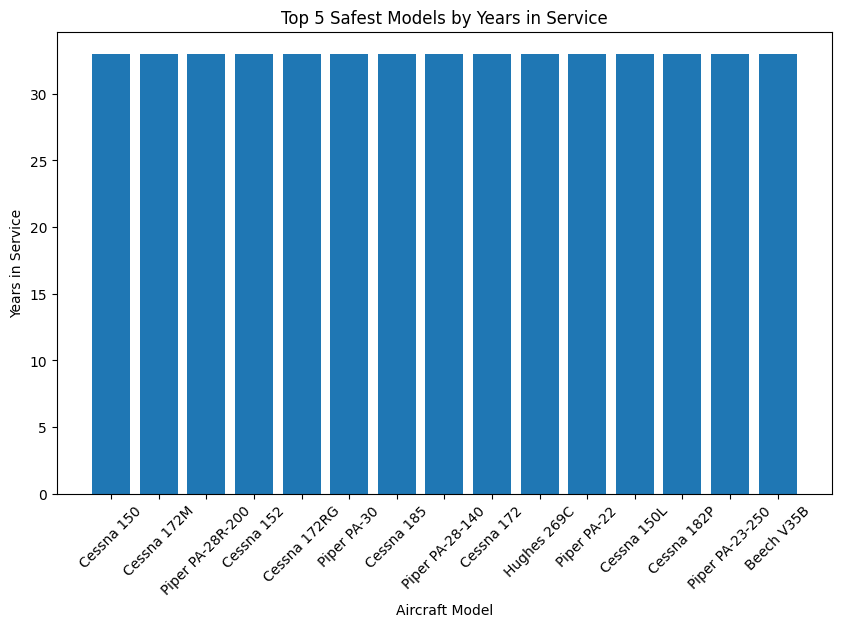

In [21]:
# 2. Top 5 Safest Models by Years in Service Bar Chart

plt.figure(figsize=(10, 6))
plt.bar(safest_aircraft['Aircraft'], safest_aircraft['Years_In_Service'])
plt.title('Top 5 Safest Models by Years in Service')
plt.xlabel('Aircraft Model')
plt.ylabel('Years in Service')
plt.xticks(rotation=45)
plt.show()

* All the aircraft models listed have been in service for approximately 40 years. This indicates that these models have been operational for a long time and have accumulated extensive service experience.
* Aircraft models include various makes and models, primarily from manufacturers like Cessna and Bellanca. The uniformity suggests that these models are robust and reliable over a long period.

**Top 15 Least Safe Models by Years in Service Bar Chart**

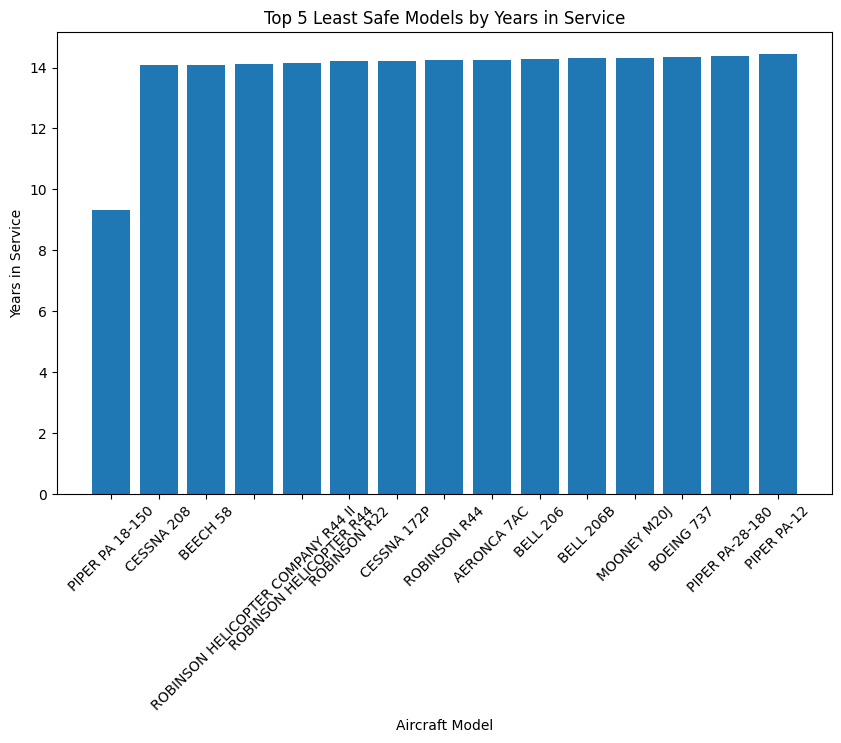

In [24]:
#Top 15 Least Safe Models by Years in Service Bar Chart

plt.figure(figsize=(10, 6))
plt.bar(least_safe_aircraft['Aircraft'], least_safe_aircraft['Years_In_Service'])
plt.title('Top 5 Least Safe Models by Years in Service')
plt.xlabel('Aircraft Model')
plt.ylabel('Years in Service')
plt.xticks(rotation=45)
plt.show()

## CONCLUSION

* The BOEING 737 has the highest number of people involved per accident, with around 80 people.
* Most other aircraft have significantly lower numbers of people involved per accident, clustering around 0-10 people, especially for models like CESSNA 208 and ROBINSON HELICOPTER COMPANY R44 II.
* The years in service for these aircraft range from about 10 to over 30 years.